In [1]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import scipy
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [3]:
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Softmax
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import LeakyReLU

In [17]:
image_gen = ImageDataGenerator(validation_split=0.15, rescale=1.0/255.0, width_shift_range=0, height_shift_range=0, zoom_range=0.1)
dataframe = pd.read_csv("../assets/data/characters/labels.txt", delim_whitespace=True)

In [18]:
training_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe, 
    directory="../assets/data/characters/",
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=20,
    classes=None,
    class_mode="categorical",
    shuffle=True,
    target_size=(36, 36)
)

Found 7943 validated image filenames belonging to 26 classes.


In [19]:
validation_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe, 
    directory="../assets/data/characters/",
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=20,
    classes=None,
    class_mode="categorical",
    shuffle=True,
    target_size=(36, 36)
)

Found 1401 validated image filenames belonging to 26 classes.


In [7]:
input_shape = (36, 36, 3)
alpha = 0.2

inputs = Input(shape=input_shape)

x = Conv2D(16, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = SeparableConv2D(32, (3, 3))(x)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3))(x)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(64)(x)
x = LeakyReLU(alpha)(x)

x = Dense(26, activation="softmax")(x)
outputs = x

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [20]:
model = keras.models.load_model("characters.h5")

In [9]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 16)        448       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 34, 34, 16)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 16)        0         
_________________________________________________________________
separable_conv2d_13 (Separab (None, 15, 15, 32)        688       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 15, 15, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 32)          0   

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.00001),
    loss="mse",
    metrics=["accuracy"])

In [31]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
)

Epoch 1/10
397/397 [==============================] - 14s 36ms/step - loss: 1.5741e-04 - accuracy: 0.9981 - val_loss: 0.0040 - val_accuracy: 0.9936
Epoch 2/10
397/397 [==============================] - 14s 34ms/step - loss: 1.6424e-04 - accuracy: 0.9976 - val_loss: 4.6561e-07 - val_accuracy: 0.9978
Epoch 3/10
397/397 [==============================] - 15s 37ms/step - loss: 1.7970e-04 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9964
Epoch 4/10
397/397 [==============================] - 14s 35ms/step - loss: 1.1488e-04 - accuracy: 0.9987 - val_loss: 9.6889e-05 - val_accuracy: 0.9942
Epoch 5/10
397/397 [==============================] - 14s 36ms/step - loss: 1.2962e-04 - accuracy: 0.9984 - val_loss: 2.4538e-06 - val_accuracy: 0.9920
Epoch 6/10
397/397 [==============================] - 13s 33ms/step - loss: 1.3862e-04 - accuracy: 0.9981 - val_loss: 9.8439e-06 - val_accuracy: 0.9964
Epoch 7/10
397/397 [==============================] - 13s 32ms/step - loss: 1.2887e-04 - accurac

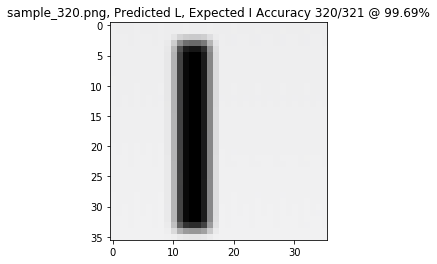

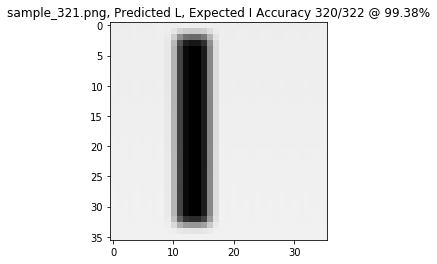

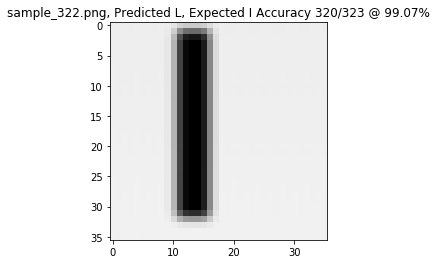

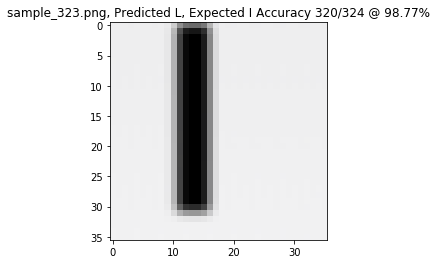

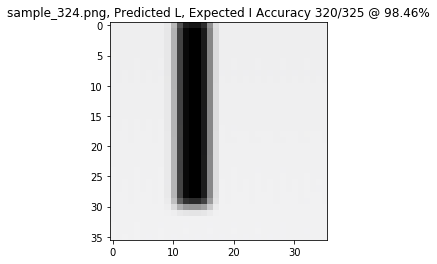

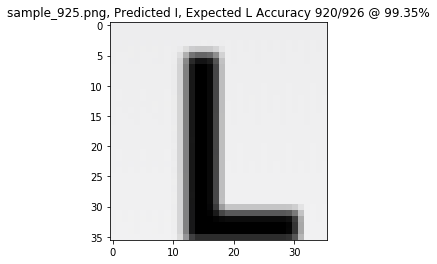

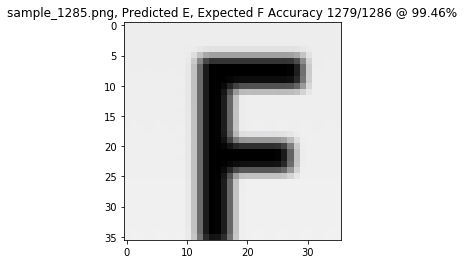

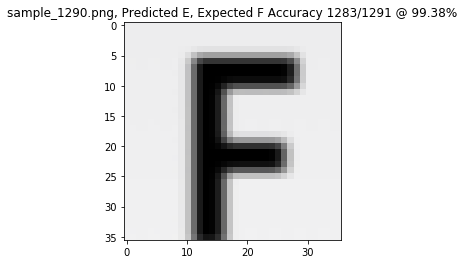

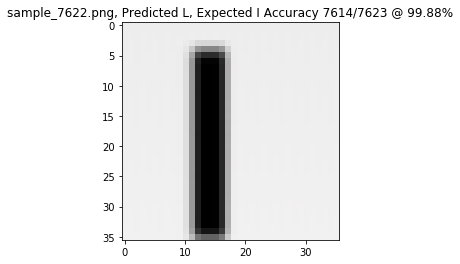

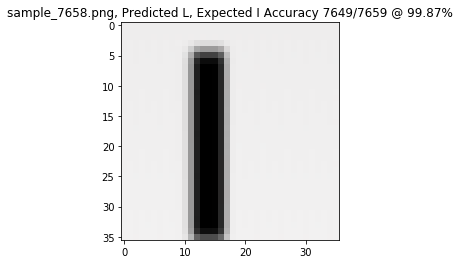

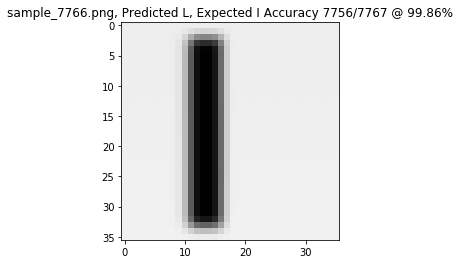

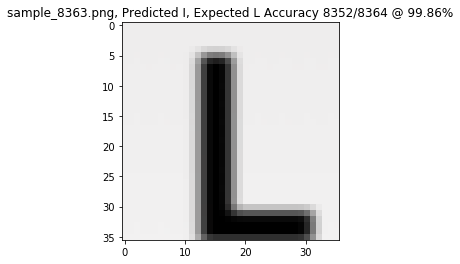

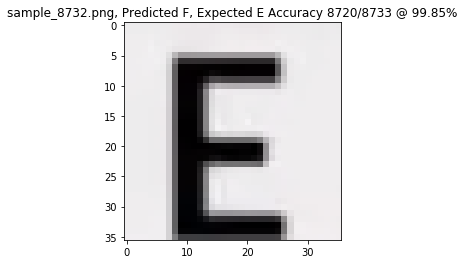

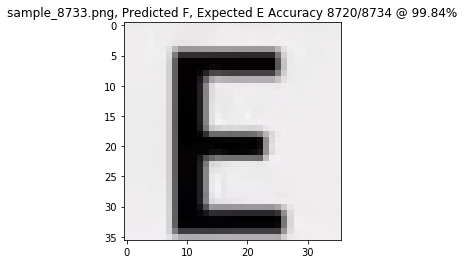

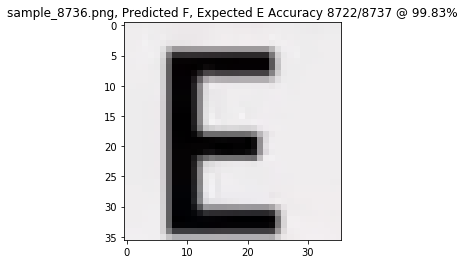

In [32]:
test_directory = "../assets/data/characters"
total_samples = 0
total_correct = 0

for i, row in dataframe.iterrows():
    filename = row['filename']
    character = row['category']
    
    filepath = f"{test_directory}/{filename}"
    
    if not os.path.exists(filepath):
        continue
    
    image = cv2.imread(filepath)
    image = image/255
    
    prediction = model.predict(np.array([image]))
    char_index = np.argmax(prediction, axis=1)
    pred_character = chr(char_index + ord('A'))
    
    total_samples += 1
    
    if pred_character == character:
        total_correct += 1
        continue
    
    plt.title(f"{filename}, Predicted {pred_character}, Expected {character} "+
              f"Accuracy {total_correct}/{total_samples} @ {total_correct/total_samples * 100:.2f}%")
    plt.imshow(image)
    plt.show()

In [35]:
model.save("characters.h5")
#model.save("../assets/models/characters.h5")